In [90]:
import numpy as np
import matplotlib.pyplot as plt
import time
from subprocess import Popen, PIPE

def surge_exp(E,p,lmbd,E_th):
    x=E-E_th
    return np.heaviside(x,1)*((np.exp(1)/lmbd)**p)*(x**p)*np.exp(-p*x/lmbd)
    
def surge_pwr(E,p,lmbd,E_th):
    x=E-E_th
    return np.heaviside(x,1)*(lmbd**p)*(p+1)**(p+1)*x/(x+p*lmbd)**(p+1)

In [120]:
from scipy.optimize import curve_fit

def optimize(A):
    x=A[:,0]
    y=A[:,1]
    
    print(x)
    plt.loglog(x,y,'b-')
    popt, pcov = curve_fit(surge_pwr, x, y, bounds=([1,1,-100],[3,100,100]))
    print(popt)
    plt.loglog(x, surge_pwr(x, *popt), 'r-')
    plt.show()

'''    
Constrain the optimization to the region of 0 <= a <= 3, 0 <= b <= 1 and 0 <= c <= 0.5:

>>>
>>> popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [3., 1., 0.5]))
>>> popt
array([ 2.43708906,  1.        ,  0.35015434])
>>> plt.plot(xdata, func(xdata, *popt), 'g--',
...          label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
>>>
>>> plt.xlabel('x')
>>> plt.ylabel('y')
>>> plt.legend()
>>> plt.show()
'''

"    \nConstrain the optimization to the region of 0 <= a <= 3, 0 <= b <= 1 and 0 <= c <= 0.5:\n\n>>>\n>>> popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [3., 1., 0.5]))\n>>> popt\narray([ 2.43708906,  1.        ,  0.35015434])\n>>> plt.plot(xdata, func(xdata, *popt), 'g--',\n...          label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))\n>>>\n>>> plt.xlabel('x')\n>>> plt.ylabel('y')\n>>> plt.legend()\n>>> plt.show()\n"

In [280]:
import tensorflow as tf

def optimize(A):
    eps=1e-10
    sig=tf.nn.relu(tf.Variable(1, dtype=tf.float32))
    p = tf.nn.relu(tf.Variable(1, dtype=tf.float32))
    lmbd = tf.nn.relu(tf.Variable(10, dtype=tf.float32))
    E_th = tf.Variable(10, dtype=tf.float32)
    x=tf.nn.reluA[:,0]-E_th
    y=A[:,1]
    
    surge=sig*tf.pow(lmbd,p)*tf.pow(p+1,p+1)*x/tf.pow(tf.nn.relu(x+p*lmbd)+eps,p+1)
    #loss=tf.reduce_sum(tf.square(surge-y))
    loss=tf.reduce_sum(tf.abs(tf.log((y+eps)/(surge+eps))))
    
    optimizer = tf.train.GradientDescentOptimizer(0.001)
    train = optimizer.minimize(loss)

    init = tf.initializers.global_variables()
    hist=[]
    with tf.Session() as session:
        session.run(init)
        for step in range(4):  
            print(session.run(sig),session.run(p),session.run(lmbd),session.run(E_th),session.run(loss))
            plt.loglog(session.run(surge))
            plt.show()
            session.run(train)
            hist.append(np.max(session.run(loss)))
        print(session.run(sig),session.run(p),session.run(lmbd),session.run(E_th),session.run(loss))
        plt.loglog(A[:,0],A[:,1])
        plt.loglog(A[:,0],session.run(surge))
        plt.show()
    plt.plot(hist)
    plt.show()

In [266]:
def ReadDatabase(f):
    print("Happy that I am called!")
    for line in f:
        A=[]
        if line[:5]=='-----':
            while 1:
                temp_line=f.readline()
                if temp_line[:5]=='-----':
                    break
                A.append([float(x) for x in temp_line.strip().split()])
            A=np.array(A)
            
            if len(A)>0:
                print(np.shape(A))
                A[:,1]=A[:,1]*1e20
                optimize(A)
                #return
            f.readline()
            collision_type=f.readline()
            if collision_type[:5]=='xxxxx' or collision_type[:5]=='*****': return
            else: print(collision_type)
    
def ReadInput():
    f=open("Ar.txt","r")
    for line in f:
        if line[:5]=='*****':
            f.readline()
            temp_line=f.readline()
            if(temp_line.strip()=='ELASTIC'):
                print(temp_line)
                ReadDatabase(f)
                break
    f.close()
        

In [245]:
def Input(Y,m):
    A=Y[:m]
    p=Y[m:2*m]
    lmbd=Y[2*m:3*m]
    E_th=Y[3*m:]
    
    n=500
    E=np.logspace(-1,3,n)
    
    sigma_m=0
    for i in range(m):
        sigma_m+=A[i]*1e-20*surge_pwr(E,p[i],lmbd[i],E_th[i])
    
    f=open("LXCat0.txt","w")
    f.write('----------------------\n')
    f.write('ELASTIC\nAr\n')
    f.write('1.371541e-4 / mass ratio\n')
    f.write('----------------------\n')
    
    for i in range(n):
        f.write(str(E[i])+' '+str(sigma_m[i])+'\n')

    '''
    f.write('----------------------\n')
    f.write('EXCITATION\nSurge\n')
    f.write(str(E_th)+' / Thresold Energy\n')
    f.write('1.371541e-4 / mass ratio\n')
    f.write('----------------------\n')
    sigma_exc=slope*(E-E_th)*np.heaviside(E-E_th,1)
    for i in range(n):
        f.write(str(E[i])+' '+str(sigma_exc[i])+'\n')
    '''

    plt.loglog(E,(sigma_m)*1e20)
    plt.show()
    
    f.close()
    
def ex(grid=100,E_min=1e-3,E_max=1e3,n=1000):
        f=open("ex.dat","w")
        f.write("READCOLLISIONS\n")
        f.write("LXCat0.txt\nSurge\n1\n")
        f.write("CONDITIONS\n")
        f.write("1       / Electric field / N (Td)\n")
        f.write("0        / Angular field frequency / N (m3/s)\n")
        f.write("0.        / Cosine of E-B field angle\n")
        f.write("0.       / Gas temperature (K)\n")
        f.write("300.      / Excitation temperature (K)\n")
        f.write("0.        / Transition energy (eV)\n")
        f.write("0.        / Ionization degree\n")
        f.write("1e-6      / Plasma density (1/m3)\n")
        f.write("1.        / Ion charge parameter\n")
        f.write("1.        / Ion/neutral mass ratio\n")
        f.write("1         / e-e momentum effects: 0=No; 1=Yes*\n")
        f.write("1         / Energy sharing: 1=Equal*; 2=One takes all\n")
        f.write("1         / Growth: 1=Temporal*; 2=Spatial; 3=Not included; 4=Grad-n expansion\n")
        f.write("0.        / Maxwellian mean energy (eV) \n")
        f.write(str(grid)+"      / # of grid points\n")
        f.write("0         / Manual grid: 0=No; 1=Linear; 2=Parabolic \n")
        f.write("1000.      / Manual maximum energy (eV)\n")
        f.write("1e-10     / Precision\n")
        f.write("1e-5      / Convergence\n")
        f.write("1000      / Maximum # of iterations\n")
        f.write("1        / Gas composition fractions\n")
        f.write("1         / Normalize composition to unity: 0=No; 1=Yes\n")
        f.write("RUNSERIES\n")
        f.write("1          / Variable: 1=E/N; 2=Mean energy; 3=Maxwellian energy \n")
        f.write(str(E_min)+" "+str(E_max)+"  / Min Max\n")
        f.write(str(n)+"         / Number \n")
        f.write("3          / Type: 1=Linear; 2=Quadratic; 3=Exponential\n")
        f.write("SAVERESULTS\n")
        f.write("Surge.dat        / File \n")
        f.write("3        / Format: 1=Run by run; 2=Combined; 3=E/N; 4=Energy; 5=SIGLO; 6=PLASIMO\n")
        f.write("1        / Conditions: 0=No; 1=Yes\n")
        f.write("1        / Transport coefficients: 0=No; 1=Yes\n")
        f.write("1        / Rate coefficients: 0=No; 1=Yes\n")
        f.write("0        / Reverse rate coefficients: 0=No; 1=Yes\n")
        f.write("0        / Energy loss coefficients: 0=No; 1=Yes\n")
        f.write("1        / Distribution function: 0=No; 1=Yes \n")
        f.write("0        / Skip failed runs: 0=No; 1=Yes\n")
        f.write("END")
        f.close()
        
def Bolsig():
    t=time.time()
    process = Popen(['./bolsigminus', 'ex.dat'], stdout=PIPE, stderr=PIPE)
    stdout, stderr = process.communicate()
    #print (stdout)


In [246]:
def Output(n=1000):
    f=open("Surge.dat","r")
    
    E=np.zeros(n)
    out=np.zeros((n,3))
    for line in f:
        if line[:8]=='E/N (Td)' and line[8:].strip()=='Mean energy (eV)':
            for i in range(n):
                l=f.readline().strip()
                if len(l)==0: break
                E[i], out[i,0] = [float(x) for x in l.split()]
        if line[:8]=='E/N (Td)' and line[8:].strip()=='Mobility *N (1/m/V/s)':
            for i in range(n):
                l=f.readline().strip()
                if len(l)==0: break
                E[i], out[i,1] = [float(x) for x in l.split()]
        if line[:8]=='E/N (Td)' and line[8:].strip()=='Diffusion coefficient *N (1/m/s)':
            for i in range(n):
                l=f.readline().strip()
                if len(l)==0: break
                E[i], out[i,2] = [float(x) for x in l.split()]

    out[:,1]=out[:,1]*E*1e-21 #Drift Velocity
    out[:,2]=out[:,2]*1e-24 #Diffusion coefficient
    
    plt.loglog(E,out[:,0])
    plt.loglog(E,out[:,1])
    plt.loglog(E,out[:,2])
    plt.show()
    
    #print('time:',time.time()-t)
    return np.log10(out)

In [247]:
'''
cross=open('Y.csv','wb')
trans=open('X.csv','wb')

n=1

t=time.time()

for i in range(n):
    Y=ReadInput()
    Y=Extrapolate(Y)
    np.savetxt(cross,np.reshape(Y,(1,-1)),delimiter=',')
    
    Input(Y[i,:],m)
    ex(grid=100,E_min=0.1,E_max=1e3,n=1000) #n cannot be more than 1000
    Bolsig()
    X=Output(n=1000)
    np.savetxt(trans,np.reshape(X,(1,-1)),delimiter=',')
    print(Y[i,:m],Y[i,m:2*m],Y[i,2*m:3*m],Y[i,3*m:],i,end=' ')
print(time.time()-t)
cross.close()
trans.close()
'''

"\ncross=open('Y.csv','wb')\ntrans=open('X.csv','wb')\n\nn=1\n\nt=time.time()\n\nfor i in range(n):\n    Y=ReadInput()\n    Y=Extrapolate(Y)\n    np.savetxt(cross,np.reshape(Y,(1,-1)),delimiter=',')\n    \n    Input(Y[i,:],m)\n    ex(grid=100,E_min=0.1,E_max=1e3,n=1000) #n cannot be more than 1000\n    Bolsig()\n    X=Output(n=1000)\n    np.savetxt(trans,np.reshape(X,(1,-1)),delimiter=',')\n    print(Y[i,:m],Y[i,m:2*m],Y[i,2*m:3*m],Y[i,3*m:],i,end=' ')\nprint(time.time()-t)\ncross.close()\ntrans.close()\n"

ELASTIC

Happy that I am called!
(282, 2)
1.0 1.0 10.0 10.0 3471.83


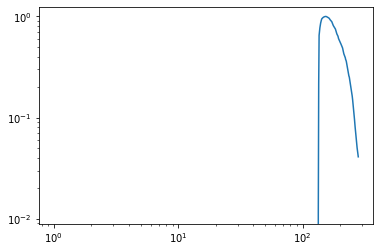

1.148 nan nan nan nan


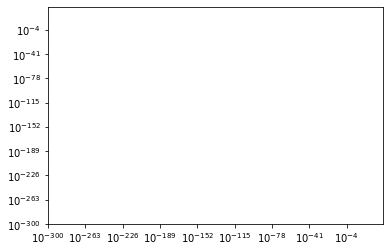

nan nan nan nan nan


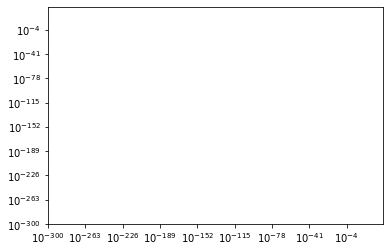

nan nan nan nan nan


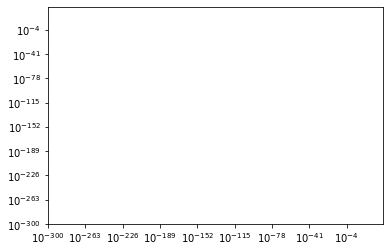

nan nan nan nan nan


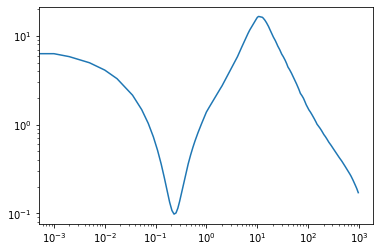

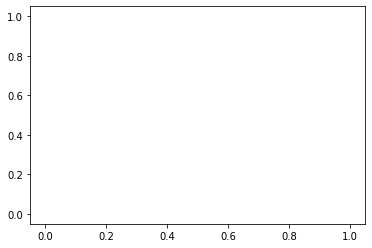

EXCITATION

(400, 2)
1.0 1.0 10.0 10.0 2306.612


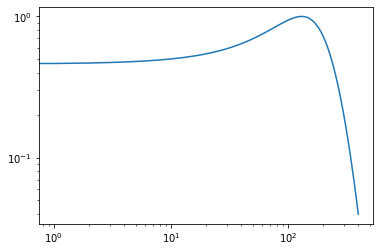

0.6 1.2994859 9.986923 10.020091 2015.7534


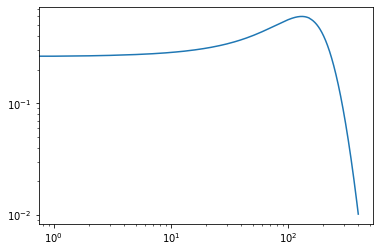

0.0 1.5746902 9.969168 10.041054 6526.4395


/home/vinit/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


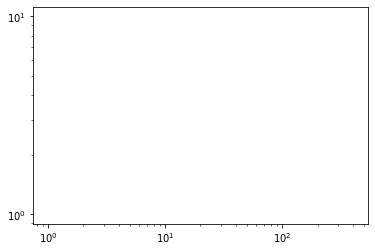

0.0 1.5746902 9.969168 10.041054 6526.4395


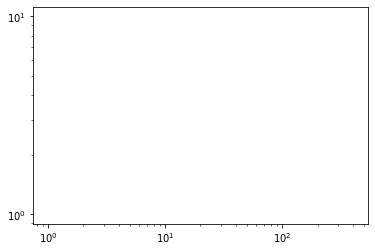

0.0 1.5746902 9.969168 10.041054 6526.4395


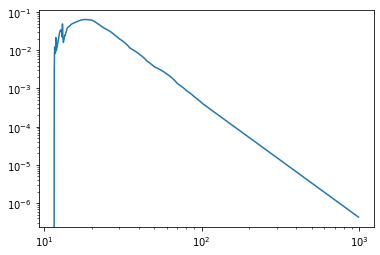

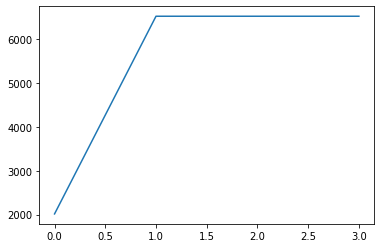

EXCITATION

(214, 2)
1.0 1.0 10.0 10.0 606.2702


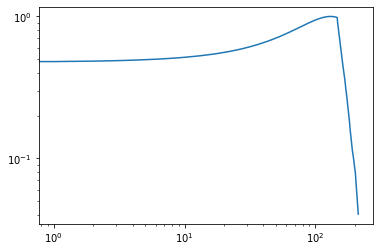

0.786 1.1027006 10.000033 10.020663 543.9508


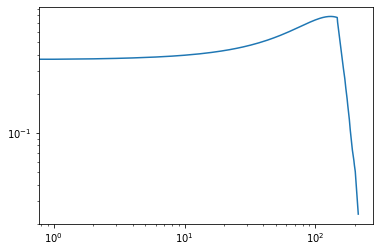

0.5137353 1.2017161 9.999695 10.041987 443.74683


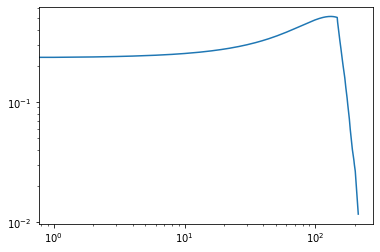

0.120536745 1.2654603 10.000396 10.063943 230.5773


KeyboardInterrupt: 

In [281]:
ReadInput()